# Projet Datascientest - Compagnon immo

<code>mar25_bds_compagnon_immo_1</code>


---

## Modélisation évolution des prix - v4.0

---

### Notebook de debug sur la série temporelle - R2 négatif

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip

from tabulate import tabulate

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from prophet import Prophet
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.activations import swish

import joblib

pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

### Chargement des données nettoyées

In [3]:
output_path = '../data/processed/dep_75_cleaned.csv.gz'
df_dep75 = pd.read_csv(output_path, low_memory=False, index_col='date_mutation', parse_dates=True)

#### Ajout du taux d'inflation annuel

In [5]:
# Source INSEE
df_inflation = pd.read_csv('../data/raw/inflation-2020-2024.csv', index_col=0)

df_inflation = df_inflation.drop('mois',axis=1)
df_inflation.rename(columns={'index': 'mois'}, inplace=True)
df_inflation.columns = df_inflation.columns.astype(int)
df_inflation["mois"] = df_inflation.index.astype(int)

def get_inflation(row):
    mois = row['mois']
    annee = row['annee']
    try:
        return df_inflation.loc[mois, annee]
    except KeyError:
        return np.nan

df_dep75['taux_inflation'] = df_dep75.apply(get_inflation, axis=1)

#### Ajout taux livret A et taux moyen bancaire

In [7]:
# Source Banque de France
taux_livret_a = {
     2020: 0.50,
     2021: 0.50,
     2022: 1.38,
     2023: 2.50,
     2024: 3.00,
}
taux_moyen_bancaire = {
     2020: 0.48,
     2021: 0.47,
     2022: 0.78,
     2023: 1.37,
     2024: 1.80,
}
df_dep75["taux_livret_a"] = df_dep75["annee"].map(taux_livret_a)
df_dep75["taux_moyen_bancaire"] = df_dep75["annee"].map(taux_moyen_bancaire)

In [9]:
df_dep75 = df_dep75[df_dep75['prix_m2_vente'] < 1_000_000]
df_dep75 = df_dep75.drop(['numero_disposition', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez'], axis=1)
df_dep75.sample(5)

,nature_mutation,valeur_fonciere,code_commune,code_departement,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,code_nature_culture_speciale,surface_terrain,longitude,latitude,prix_m2_vente,annee,mois,taux_inflation,taux_livret_a,taux_moyen_bancaire
date_mutation,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-30,Vente,33100000.0,75108,75,0,0.0,0,0.0,0,2.0,Appartement,36.0,2.0,S,NS,767.0,2.305291,48.872334,919444.444444,2020,6,0.2,0.50,0.48
2020-11-26,Vente,20265000.0,75108,75,0,0.0,0,0.0,0,2.0,Appartement,157.0,5.0,S,NS,254.0,2.302252,48.867271,129076.433121,2020,11,0.2,0.50,0.48
2022-12-16,Vente,8091000.0,75119,75,0,0.0,0,0.0,0,2.0,Appartement,91.0,5.0,S,NS,560.0,2.384656,48.884123,88912.087912,2022,12,5.9,1.38,0.78
2021-09-03,Vente,5150000.0,75103,75,0,0.0,0,0.0,0,4.0,Local industriel. commercial ou assimilé,29.0,0.0,S,NS,233.0,2.357976,48.867972,177586.206897,2021,9,2.2,0.50,0.47
2022-02-15,Vente,4000000.0,75118,75,0,0.0,0,0.0,0,2.0,Appartement,28.0,2.0,S,NS,198.0,2.352973,48.886802,142857.142857,2022,2,3.6,1.38,0.78


### Analyse de la série temporelle

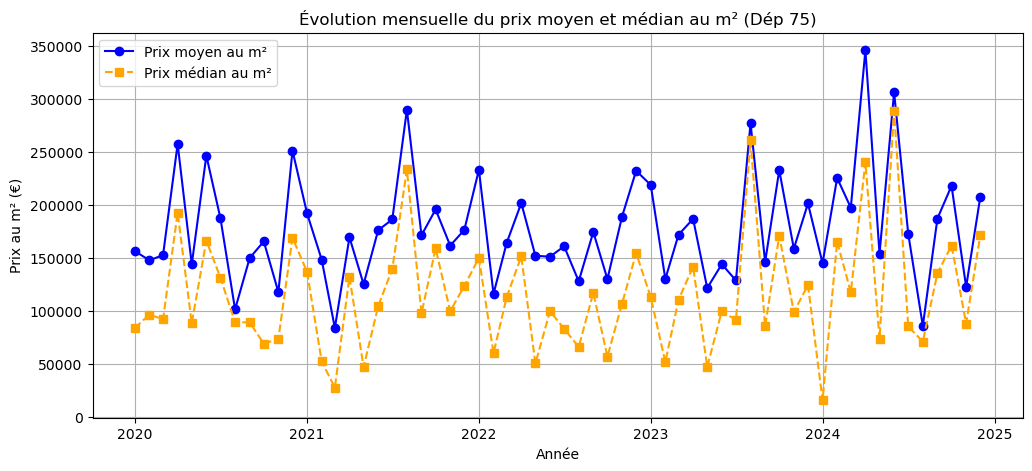

In [73]:
df_monthly = df_dep75.groupby(["annee", "mois"]).agg({
    "prix_m2_vente": ["mean", "median"],
    "valeur_fonciere": ["mean", "median"],
    "surface_reelle_bati": "mean",
    "taux_inflation": "first",
    "taux_livret_a": "first",
    "taux_moyen_bancaire": "first"
}).reset_index()

df_monthly.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_monthly.columns]
df_monthly = df_monthly.rename(columns={'annee_': 'annee', 
                                        'mois_': 'mois', 
                                        'taux_inflation_first': 'taux_inflation', 
                                        'taux_livret_a_first': 'taux_livret_a', 
                                        'taux_moyen_bancaire_first': 'taux_moyen_bancaire'})
df_monthly["date"] = pd.to_datetime(df_monthly["annee"].astype(str) + "-" + df_monthly["mois"].astype(str) + "-01")

plt.figure(figsize=(12, 5))
plt.plot(df_monthly["date"], df_monthly['prix_m2_vente_mean'], marker="o", linestyle="-", label="Prix moyen au m²", color="blue")
plt.plot(df_monthly["date"], df_monthly['prix_m2_vente_median'], marker="s", linestyle="--", label="Prix médian au m²", color="orange")

plt.xlabel("Année")
plt.ylabel("Prix au m² (€)")
plt.title("Évolution mensuelle du prix moyen et médian au m² (Dép 75)")
plt.legend()
plt.grid(True)

plt.show();

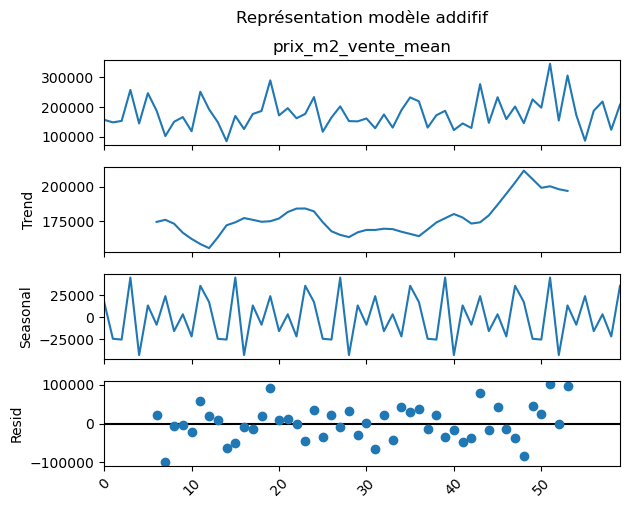

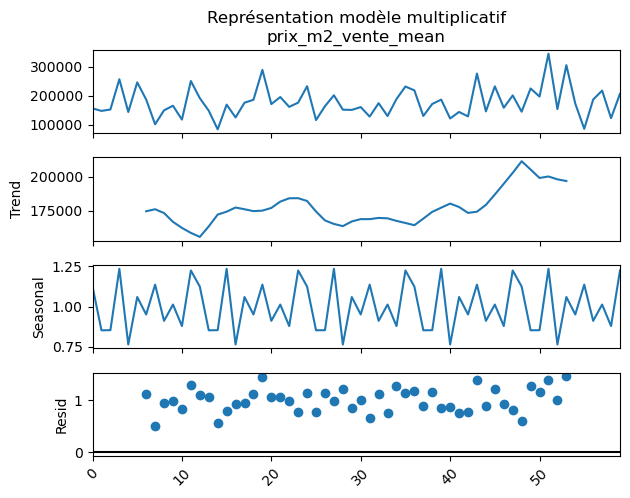

In [27]:
result = seasonal_decompose(df_monthly['prix_m2_vente_mean'], period=12)
result.plot()
plt.xticks(rotation=45)
plt.title('Représentation modèle addifif', y=5.1)
plt.show();

result = seasonal_decompose(df_monthly['prix_m2_vente_mean'], model='multiplicative', period=12)
result.plot()
plt.xticks(rotation=45)
plt.title('Représentation modèle multiplicatif', y=5.1)
plt.show();

In [29]:
decomposition_additive = seasonal_decompose(df_monthly['prix_m2_vente_mean'], period=12)
decomposition_multiplicative = seasonal_decompose(df_monthly['prix_m2_vente_mean'], model='multiplicative', period=12)

# Résidus pour les deux modèles
resid_add = decomposition_additive.resid.dropna()
resid_mult = decomposition_multiplicative.resid.dropna()

# Calcul l'écart-type des résidus
std_add = resid_add.std()
std_mult = resid_mult.std()
serie_type = 'additif' if std_add < std_mult else 'multiplicatif'

data = [
    ["Écart-type des résidus (Additif)", std_add],
    ["Écart-type des résidus (Multiplicatif) :", std_mult],
    ["Type de la série :", serie_type],
]
print(tabulate(data, headers=["Description", "Value"], tablefmt="grid"))

+------------------------------------------+---------------------+
| Description                              | Value               |
+==========================================+=====================+
| Écart-type des résidus (Additif)         | 44088.21837849062   |
+------------------------------------------+---------------------+
| Écart-type des résidus (Multiplicatif) : | 0.22841983270138763 |
+------------------------------------------+---------------------+
| Type de la série :                       | multiplicatif       |
+------------------------------------------+---------------------+


#### Transformation logarithmique

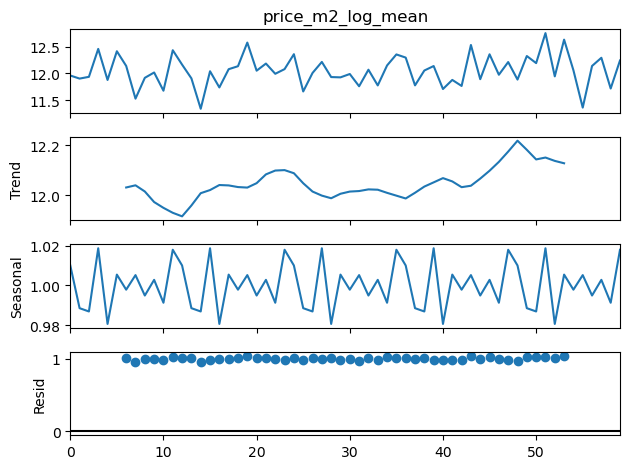

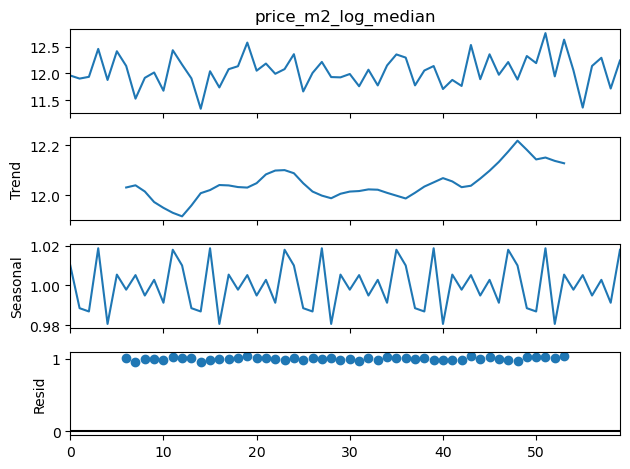

In [31]:
df_monthly['price_m2_log_mean'] = np.log(df_monthly['prix_m2_vente_mean'])
df_monthly['price_m2_log_median'] = np.log(df_monthly['prix_m2_vente_mean'])
result_mult_log = seasonal_decompose(df_monthly['price_m2_log_mean'], model="multiplicative", period=12)
result_mult_log.plot()
plt.show();

result_mult_log = seasonal_decompose(df_monthly['price_m2_log_median'], model="multiplicative", period=12)
result_mult_log.plot()
plt.show();

#### Vérification saisonnalité

<Figure size 2000x500 with 0 Axes>

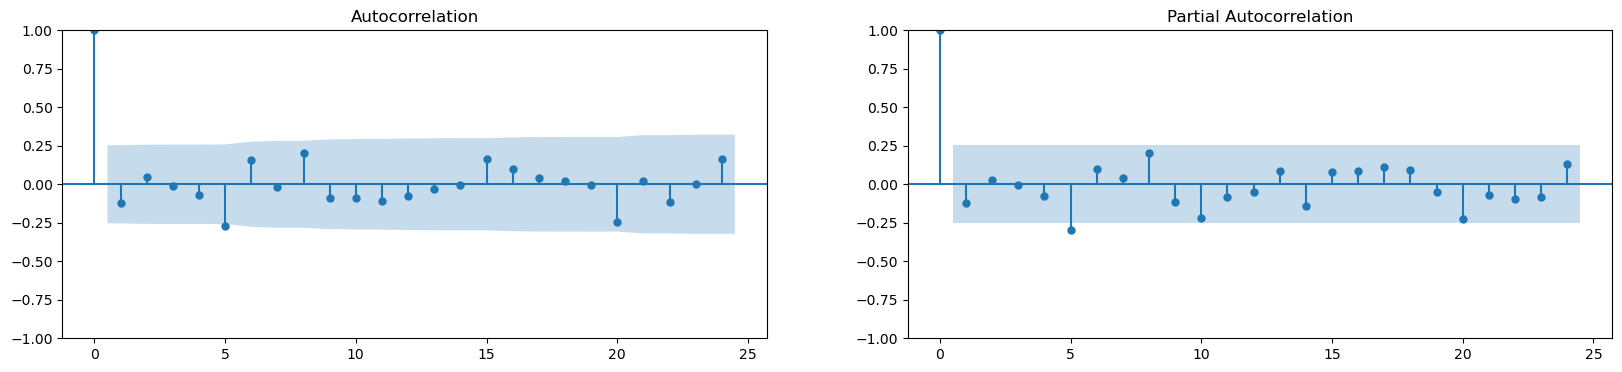

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(20, 5))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(df_monthly['price_m2_log_mean'], lags=24, ax=ax1)
plot_pacf(df_monthly['price_m2_log_mean'], lags=24, ax=ax2)
plt.show();

In [37]:
from scipy.stats import kruskal

grouped = [df_monthly[df_monthly["mois"] == mois]['prix_m2_vente_mean'] for mois in range(1, 13)]
stat, p_value = kruskal(*grouped)

print(f"Test Kruskal-Wallis : p-value = {p_value:.4f}")

Test Kruskal-Wallis : p-value = 0.0688


In [39]:
from statsmodels.tsa.stattools import adfuller

result_adf = adfuller(df_monthly['prix_m2_vente_mean'])
print(f"ADF Test (Mean): p-value = {result_adf[1]:.4f}")

result_adf_log = adfuller(df_monthly['price_m2_log_mean'])
print(f"ADF Test (Log Mean): p-value = {result_adf_log[1]:.4f}")

ADF Test (Mean): p-value = 0.0000
ADF Test (Log Mean): p-value = 0.0000


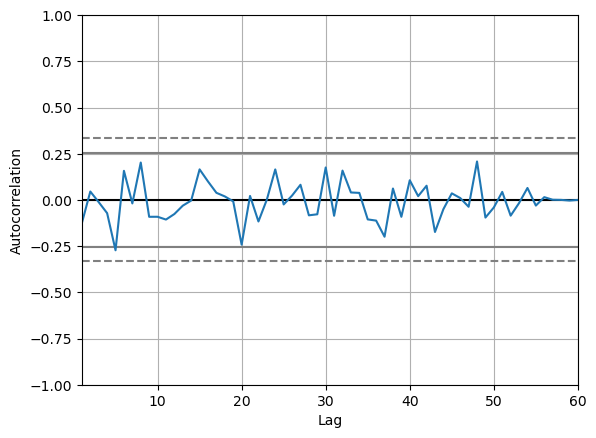

In [41]:
pd.plotting.autocorrelation_plot(df_monthly["price_m2_log_mean"]);

### SARIMA

C:\Users\tabod\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tabod\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                  price_m2_log_mean   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -10.303
Date:                            Sat, 10 May 2025   AIC                             30.606
Time:                                    11:34:27   BIC                             39.962
Sample:                                         0   HQIC                            34.141
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.011     87.319      0.000       0.977       1.022
ma.L1         -0.8923      0.445   

C:\Users\tabod\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tabod\AppData\Local\Temp\ipykernel_20572\470633637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["sarima_pred"] = model_sarima.predict(start=len(train), end=len(train) + len(test) - 1)


,Dataset,MAE,RMSE,R²,MAPE (%)
0,Train,0.452618,1.747813,-44.834537,3.773174
1,Test,0.288181,0.367220,-0.023449,2.378254


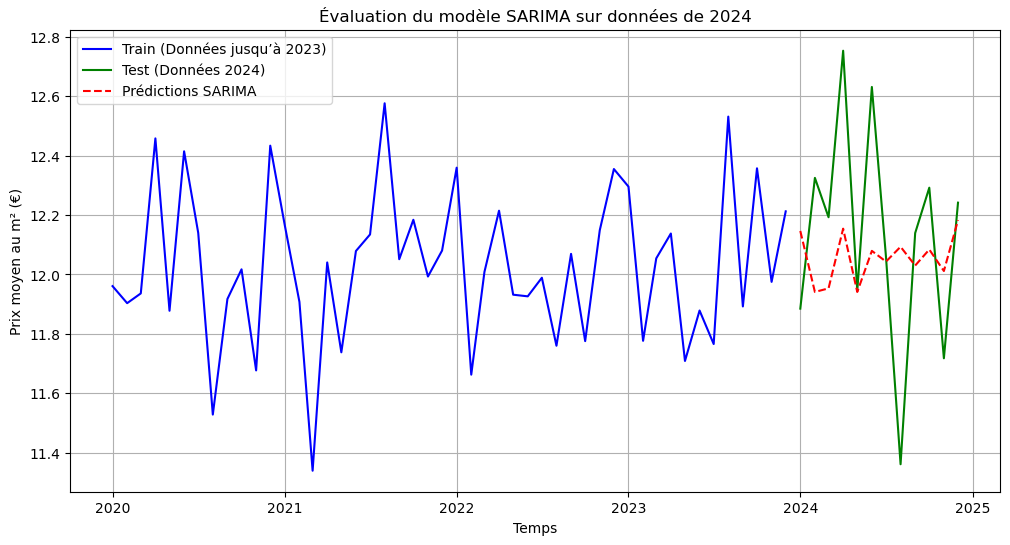

In [43]:
train = df_monthly[df_monthly["annee"] < 2024]
test = df_monthly[df_monthly["annee"] == 2024]  

model_sarima = SARIMAX(train["price_m2_log_mean"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_sarima = model_sarima.fit()

print(model_sarima.summary())

y_true_train = train["price_m2_log_mean"]
y_pred_train = model_sarima.predict(start=0, end=len(train) - 1)

mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
r2_train = r2_score(y_true_train, y_pred_train)
mape_train = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100

test["sarima_pred"] = model_sarima.predict(start=len(train), end=len(train) + len(test) - 1)

y_true_test = test["price_m2_log_mean"]
y_pred_test = test["sarima_pred"]

mae_test = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100

df_scores = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MAE": [mae_train, mae_test],
    "RMSE": [rmse_train, rmse_test],
    "R²": [r2_train, r2_test],
    "MAPE (%)": [mape_train, mape_test]
})

display(df_scores)

plt.figure(figsize=(12, 6))
plt.plot(train["date"], train["price_m2_log_mean"], label="Train (Données jusqu’à 2023)", color="blue")
plt.plot(test["date"], test["price_m2_log_mean"], label="Test (Données 2024)", color="green")
plt.plot(test["date"], test["sarima_pred"], label="Prédictions SARIMA", color="red", linestyle="--")

plt.xlabel("Temps")
plt.ylabel("Prix moyen au m² (€)")
plt.title("Évaluation du modèle SARIMA sur données de 2024")
plt.legend()
plt.grid(True)
plt.show();

### Prophet

12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing


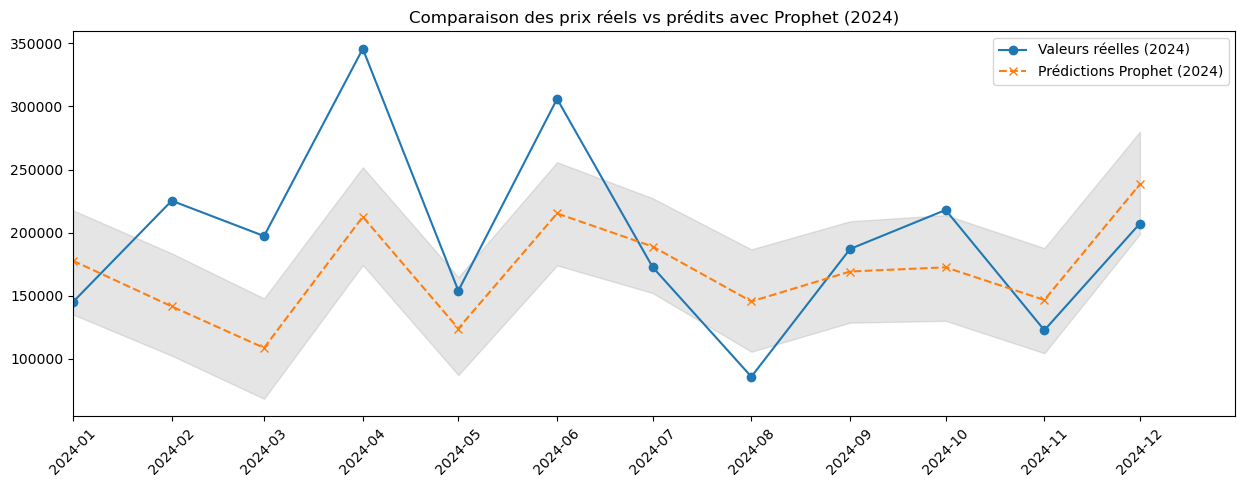

MAE: 54408.67, RMSE: 64864.59, R²: 0.14


In [41]:
df_prophet = df_monthly.reset_index()[['date','prix_m2_vente_mean']].rename(
    columns={'date': 'ds', 'prix_m2_vente_mean': 'y'}
)

df_prophet = df_monthly[['date', 
                         'prix_m2_vente_mean', 
                         'taux_inflation', 
                         'taux_livret_a', 
                         'taux_moyen_bancaire', 
                         'valeur_fonciere_mean', 
                         'surface_reelle_bati_mean']].rename(columns={'date': 'ds', 'prix_m2_vente_mean': 'y'}).dropna()


df_train = df_prophet[df_prophet["ds"].dt.year < 2024]
df_test = df_prophet[df_prophet["ds"].dt.year == 2024]

df_train = df_train.reset_index(drop=True)
df_train['ds'] = pd.to_datetime(df_train['ds'])

model_prophet = Prophet()
model_prophet.fit(df_train[['ds', 'y', 'taux_inflation', 'valeur_fonciere_mean']])


future_dates = model_prophet.make_future_dataframe(periods=12, freq="MS")
forecast = model_prophet.predict(future_dates)

forecast_2024 = forecast[forecast["ds"].dt.year == 2024]

plt.figure(figsize=(15, 5))
plt.plot(df_test["ds"], df_test["y"], label="Valeurs réelles (2024)", marker="o")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
plt.plot(forecast_2024["ds"], forecast_2024["yhat"], label="Prédictions Prophet (2024)", linestyle="dashed", marker="x")

# Intervalle de confiance
plt.fill_between(forecast_2024["ds"], forecast_2024["yhat_lower"], forecast_2024["yhat_upper"], color="gray", alpha=0.2)
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec Prophet (2024)")
plt.xticks(rotation=45)
plt.show();

mae = mean_absolute_error(df_test["y"], forecast_2024["yhat"])
rmse = np.sqrt(mean_squared_error(df_test["y"], forecast_2024["yhat"]))
r2 = r2_score(df_test["y"], forecast_2024["yhat"])

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

In [75]:
df_monthly.head()

,annee,mois,prix_m2_vente_mean,prix_m2_vente_median,valeur_fonciere_mean,valeur_fonciere_median,surface_reelle_bati_mean,taux_inflation,taux_livret_a,taux_moyen_bancaire,date,ds
0,2020,1,156467.891493,84031.721591,1.136464e+07,4500000.0,130.179894,1.5,0.5,0.48,2020-01-01,2020-01-01
1,2020,2,147749.177738,96572.141561,1.302441e+07,5250000.0,236.117647,1.4,0.5,0.48,2020-02-01,2020-02-01
2,2020,3,152679.887446,92250.000000,2.850226e+07,6300000.0,388.397683,0.7,0.5,0.48,2020-03-01,2020-03-01
3,2020,4,257291.040251,192515.370222,2.795786e+07,12104743.0,140.705556,0.3,0.5,0.48,2020-04-01,2020-04-01
4,2020,5,144013.021739,88533.333333,1.012853e+07,5552000.0,131.574850,0.4,0.5,0.48,2020-05-01,2020-05-01


#### Optimisation prophet

In [69]:
# Meilleurs paramètres : {'changepoint_prior_scale': 0.0001, 'changepoint_range': 1.0, 'n_changepoints': 50, 'seasonality_prior_scale': 100.0, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False}
param_grid = {
    'changepoint_prior_scale': [0.0001, 0.001, 0.005],
    'changepoint_range': [0.9, 1.0],
    'n_changepoints': [50, 100],
    'seasonality_prior_scale': [50.0, 100.0],
    'seasonality_mode': ['multiplicative'],
}
df_monthly['ds'] = df_prophet['ds'] 
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

df_prophet = df_monthly[['date', 
                         'prix_m2_vente_mean', 
                         'taux_inflation', 
                         'taux_livret_a', 
                         'taux_moyen_bancaire', 
                         'valeur_fonciere_mean', 
                         'surface_reelle_bati_mean']].rename(columns={'date': 'ds', 'prix_m2_vente_mean': 'y'}).dropna()

best_mae = float("inf")
best_params = None

train_p = df_prophet.iloc[:-12]
test_p = df_prophet.iloc[-12:]

for params in all_params:
    model = Prophet(**params)
    model.fit(train_p)

    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    y_true = test_p['y'].values
    y_pred = forecast.set_index('ds').loc[test_p['ds']]['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_params = params

print("Meilleurs paramètres :", best_params)
print("MAE minimal :", best_mae)

12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:49 - cmdstanpy - INFO - Chain [1] done processing
12:31:49 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing
12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:55 - cmdstanpy - INFO - Chain [1] done processing
12:31:55 - cmdstanpy - INFO - Chain [1] start processing
12:31:55 - cmdstanpy - INFO - Chain [1]

Meilleurs paramètres : {'changepoint_prior_scale': 0.0001, 'changepoint_range': 1.0, 'n_changepoints': 50, 'seasonality_prior_scale': 100.0, 'seasonality_mode': 'multiplicative'}
MAE minimal : 52834.182359736435


12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing


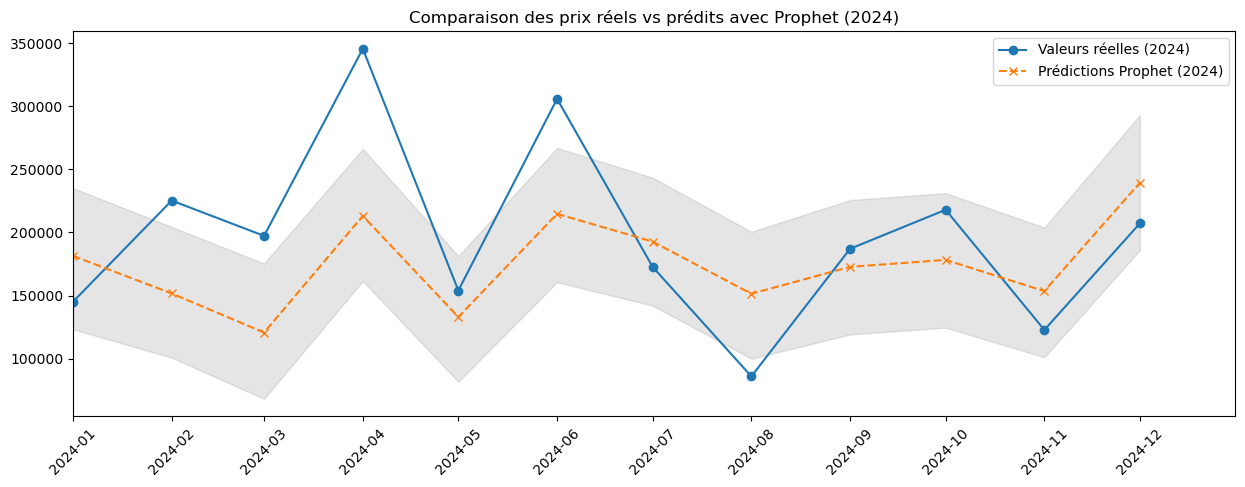

MAE: 52834.18, RMSE: 62852.32, R²: 0.19


In [73]:
df_prophet = df_monthly[['date', 
                         'prix_m2_vente_mean', 
                         'taux_inflation', 
                         'taux_livret_a', 
                         'taux_moyen_bancaire', 
                         'valeur_fonciere_mean', 
                         'surface_reelle_bati_mean']].rename(columns={'date': 'ds', 'prix_m2_vente_mean': 'y'}).dropna()


df_train = df_prophet[df_prophet["ds"].dt.year < 2024]
df_test = df_prophet[df_prophet["ds"].dt.year == 2024]

df_train = df_train.reset_index(drop=True)
df_train['ds'] = pd.to_datetime(df_train['ds'])

model_prophet = Prophet(**best_params)
model_prophet.fit(df_train[['ds', 
                            'y', 
                            'taux_inflation', 
                            'valeur_fonciere_mean', 
                            'taux_moyen_bancaire', 
                            'surface_reelle_bati_mean', 
                            'taux_livret_a']])

future_dates = model_prophet.make_future_dataframe(periods=12, freq="MS")
forecast = model_prophet.predict(future_dates)

forecast_2024 = forecast[forecast["ds"].dt.year == 2024]

plt.figure(figsize=(15, 5))

# Valeurs réelles
plt.plot(df_test["ds"], df_test["y"], label="Valeurs réelles (2024)", marker="o")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
# Prédictions Prophet
plt.plot(forecast_2024["ds"], forecast_2024["yhat"], label="Prédictions Prophet (2024)", linestyle="dashed", marker="x")

# Intervalle de confiance
plt.fill_between(forecast_2024["ds"], forecast_2024["yhat_lower"], forecast_2024["yhat_upper"], color="gray", alpha=0.2)
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec Prophet (2024)")
plt.xticks(rotation=45)
plt.show();
# Comparaison entre valeurs réelles et prédites
mae = mean_absolute_error(df_test["y"], forecast_2024["yhat"])
rmse = np.sqrt(mean_squared_error(df_test["y"], forecast_2024["yhat"]))
r2 = r2_score(df_test["y"], forecast_2024["yhat"])

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

### Deep Learning

#### Train test Split

In [19]:
df_train = df_dep75[df_dep75['annee'] < 2024]
df_test = df_dep75[df_dep75['annee'] == 2024]

X_train = df_train.drop(['prix_m2_vente'], axis=1)
X_test = df_test.drop(['prix_m2_vente'], axis=1)

y_train = df_train['prix_m2_vente'].values.reshape(-1, 1)  
y_test = df_test['prix_m2_vente'].values.reshape(-1, 1)

In [29]:
def encode_df(X_train, X_test):

    one_hot_cols = ['type_local', 'nature_mutation']
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(X_train[one_hot_cols])
    
    X_train_ohe = pd.DataFrame(ohe.transform(X_train[one_hot_cols]), 
                               columns=ohe.get_feature_names_out(one_hot_cols),
                               index=X_train.index)
    
    X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                              columns=ohe.get_feature_names_out(one_hot_cols),
                              index=X_test.index)
    
    X_train = X_train.drop(columns=one_hot_cols)
    X_test = X_test.drop(columns=one_hot_cols)
    
    X_train = pd.concat([X_train, X_train_ohe], axis=1)
    X_test = pd.concat([X_test, X_test_ohe], axis=1)
    
    freq_cols = ['code_nature_culture', 'code_nature_culture_speciale', 'code_commune', 'code_departement']
    
    for col in freq_cols:
        freq_encoding = X_train[col].value_counts(normalize=True)
    
        X_train[col] = X_train[col].map(freq_encoding).fillna(0)
        X_test[col] = X_test[col].map(freq_encoding).fillna(0)
    
    for i in range(1, 3):
        col = f'lot{i}_numero'
        X_train[col] = (X_train[col] != 0).astype(int)
        X_test[col] = (X_test[col] != 0).astype(int)
    
    print("Variables catégorielles restantes :", len(X_train.select_dtypes('object').columns))

    return X_train, X_test

X_train, X_test = encode_df(X_train, X_test)

Variables catégorielles restantes : 0


#### Callbacks

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
]

#### Modèle GRU (Gated Recurrent Unit)

In [25]:
def create_sequences(X, y, timesteps=12):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        if i + timesteps < len(y):
            X_seq.append(X[i:i+timesteps])
            y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq).reshape(-1, 1)

def display_scores(y_test_seq, y_pred, model_name, scaler_name):
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_seq = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
    r2 = r2_score(y_test_seq, y_pred)
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    
    scores_gru = pd.DataFrame([{
        'Modèle': model_name,
        'Scaler': scaler_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }])

    display(scores_gru)


def train_and_evaluate_gru(X_train_seq , y_train_seq, X_test_seq, y_test_seq, scaler_y, scaler_name, epochs=50, batch_size=8):
    
    inputs = Input(shape=(timesteps, X_train_scaled.shape[1]))
    x = GRU(50, activation="relu", return_sequences=False)(inputs)
    x = Dense(1)(x)
    
    model_gru = Model(inputs=inputs, outputs=x)

    model_gru.compile(optimizer="adam", loss="mse")
    history_gru = model_gru.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

    y_pred_gru = model_gru.predict(X_test_seq)

    display_scores(y_test_seq, y_pred_gru, 'GRU', scaler_name)

> Test avec StandardScaler

In [109]:
X_train, X_test = encode_df(X_train, X_test)

std_x_scaler = StandardScaler()
X_train_scaled = std_x_scaler.fit_transform(X_train)
X_test_scaled = std_x_scaler.transform(X_test)

std_y_scaler = StandardScaler()
y_train_scaled = std_y_scaler.fit_transform(y_train)
y_test_scaled = std_y_scaler.transform(y_test)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

train_and_evaluate_gru(X_train_seq, y_train_seq, X_test_seq, y_test_seq, std_y_scaler, 'standard')

Variables catégorielles restantes : 0
Epoch 1/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9197 - val_loss: 1.0029 - learning_rate: 0.0010
Epoch 2/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7041 - val_loss: 0.8807 - learning_rate: 0.0010
Epoch 3/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6971 - val_loss: 1.1154 - learning_rate: 0.0010
Epoch 4/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6741 - val_loss: 0.9236 - learning_rate: 0.0010
Epoch 5/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6378 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 6/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6392 - val_loss: 0.9362 - learning_rate: 0.0010
Epoch 7/50
1385/1388 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6414
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6415 - val_loss: 1.0748 - learning_rate: 0.0010
Epoch 8/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s

,Modèle,Scaler,MAE,RMSE,R2
0,GRU,standard,1.333648,1.977789,0.28786


> Test avec RobustScaler

In [31]:
robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

train_and_evaluate_gru(X_train_seq, y_train_seq, X_test_seq, y_test_seq, robust_y_scaler, 'robust')

Epoch 1/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8870 - val_loss: 0.6785 - learning_rate: 0.0010
Epoch 2/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5868 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 3/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5351 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 4/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5857 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 5/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5637 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 6/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5450 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 7/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5748 - val_loss: 0.6517 - learning_rate: 0.0010
Epoch 8/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5574 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 9/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5300 - val_loss: 0.6834 - learning_rate:

NameError: name 'scaler_y' is not defined

> Test avec MinMaxScaler

In [113]:
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

train_and_evaluate_gru(X_train_seq, y_train_seq, X_test_seq, y_test_seq, y_scaler, 'min_max')

Epoch 1/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0421 - val_loss: 0.0442 - learning_rate: 0.0010
Epoch 2/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0340 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 3/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0322 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 4/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0300 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 5/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0299 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 6/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0285 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 7/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0294 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 8/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0284 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 9/50
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0275 - val_loss: 0.0363 - learning_rate:

,Modèle,Scaler,MAE,RMSE,R2
0,GRU,min_max,0.267796,0.383388,0.322537


#### Modèle LSTM

In [114]:
def train_and_evaluate_lstm(X_train_seq , y_train_seq, X_test_seq, y_test_seq, scaler_y, scaler_name, epochs=50, batch_size=8):

    inputs = Input(shape=(timesteps, X_train_scaled.shape[1]))
    x = LSTM(50, activation="relu", return_sequences=False)(inputs)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    
    model_lstm = Model(inputs=inputs, outputs=x)

    model_lstm.compile(optimizer="adam", loss="mse")
    history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

    y_pred_lstm = model_lstm.predict(X_test_seq)

    display_scores(y_test_seq, y_pred_lstm, 'LSTM', scaler_name)

def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

> Test avec StandardScaler

In [115]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

timesteps = 12
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

train_and_evaluate_lstm(X_train_seq , y_train_seq, X_test_seq, y_test_seq, scaler_y, 'standard',  batch_size=16)

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9785 - val_loss: 1.1942 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8096 - val_loss: 1.1265 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7602 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6962 - val_loss: 0.9674 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6801 - val_loss: 1.0931 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6547 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6896 - val_loss: 0.9242 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6876 - val_loss: 0.9355 - learning_rate: 0.0010
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6686 - val_loss: 0.9448 - learning_rate: 0.0010
Epoch 10/5

,Modèle,Scaler,MAE,RMSE,R2
0,LSTM,standard,126557.191003,188136.65988,0.269847


> Test avec RobustScaler

In [117]:
robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

timesteps = 12
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

train_and_evaluate_lstm(X_train_seq, y_train_seq, X_test_seq, y_test_seq, robust_y_scaler, 'robust', batch_size=16)

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8974 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6392 - val_loss: 0.6686 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6064 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5854 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5855 - val_loss: 0.6596 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5988 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5769 - val_loss: 0.6768 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5535 - val_loss: 0.6761 - learning_rate: 0.0010
Epoch 9/50
689/694 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5692
Epoch 9: ReduceLROnPlateau reducing learning rate to 

,Modèle,Scaler,MAE,RMSE,R2
0,LSTM,robust,113107.932339,159861.289116,0.375646


> Test avec MinMaxScaler

In [43]:
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

timesteps = 12
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

train_and_evaluate_lstm(X_train_seq, y_train_seq, X_test_seq, y_test_seq, y_scaler, 'min_max', batch_size=16)

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0457 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0341 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0341 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0326 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0327 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0314 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0313 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0315 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0300 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 10/5

,Modèle,Scaler,MAE,RMSE,R2
0,LSTM,min_max,25238.104138,36506.952319,0.303981


#### Optimisation LSTM

In [54]:
robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

timesteps = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

model_lstm_opt = Sequential([
    LSTM(100, activation="tanh", return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[1])),
    LSTM(50, activation="tanh", return_sequences=False),
    Dense(1)
])

model_lstm_opt.compile(optimizer="adam", loss="mse")
history_lstm_opt = model_lstm_opt.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_lstm_opt = model_lstm_opt.predict(X_test_seq)

display_scores(y_test_seq, y_pred_lstm_opt, 'LSTM OPT', 'robust')

Epoch 1/50


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.7242 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5810 - val_loss: 0.6675 - learning_rate: 0.0010
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5910 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5711 - val_loss: 0.6464 - learning_rate: 0.0010
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5523 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5337 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 7/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5125 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 8/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5315 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 9/50
691/693 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5075
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0

,Modèle,Scaler,MAE,RMSE,R2
0,LSTM OPT,robust,112571.761559,159186.046018,0.378864


In [66]:
model_hybrid = Sequential([
    LSTM(100, activation="tanh", return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[1])),
    LSTM(50, activation="relu", return_sequences=True),
    Dropout(0.2), 
    GRU(50, activation="tanh", return_sequences=True),
    GRU(25, activation="relu", return_sequences=False),
    Dropout(0.2), 
    Dense(1)
])

timesteps = 36
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

model_hybrid.compile(optimizer="adam", loss="mse")
history_hybrid = model_hybrid.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_hybrid = model_hybrid.predict(X_test_seq)

display_scores(y_test_seq, y_pred_hybrid, 'LSTM + GRU', 'robust')

Epoch 1/50


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.7521 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.6173 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.5949 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.5861 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.5685 - val_loss: 0.6474 - learning_rate: 0.0010
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.5736 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 7/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.5634 - val_loss: 0.7536 - learning_rate: 0.0010
Epoch 8/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.5495 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 9/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.5537 - val_loss: 0.7036 - learning_rate: 0.0010
Epo

,Modèle,Scaler,MAE,RMSE,R2
0,LSTM + GRU,robust,111070.907116,159305.314961,0.377673


#### LSTM + GRU + Transformer

In [99]:
inputs = Input(shape=(timesteps, X_train_scaled.shape[1]))
x = MultiHeadAttention(num_heads=2, key_dim=64)(inputs, inputs)
x = LayerNormalization()(x)
x = LSTM(100, activation="tanh", return_sequences=True)(x)
x = Dropout(0.3)(x)
x = GRU(50, activation="tanh", return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model_tf = Model(inputs=inputs, outputs=x)

timesteps = 12
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

model_tf.compile(optimizer="adam", loss="mse")
history_hybrid = model_tf.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_tf = model_tf.predict(X_test_seq)

display_scores(y_test_seq, y_pred_tf, 'LSTM + GRU + Transformer', 'robust')

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.7868 - val_loss: 0.8104 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.7354 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.6448 - val_loss: 0.7892 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.6230 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5893 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6177 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.6032 - val_loss: 0.7532 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.6408 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5764 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 10

,Modèle,Scaler,MAE,RMSE,R2
0,LSTM + GRU + Transformer,robust,115888.713014,162552.792995,0.354445


In [117]:
from tensorflow.keras.layers import BatchNormalization

timesteps = 12  
input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(timesteps, input_dim))

x = Bidirectional(GRU(128, activation="tanh", return_sequences=True))(inputs)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)

x = GRU(32, activation="tanh", return_sequences=False)(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1)(x)

model_bi_gru_lstm = Model(inputs=inputs, outputs=outputs)

model_bi_gru_lstm.compile(optimizer="adam", loss="mse")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

history_hybrid = model_bi_gru_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_bi_gru_lstm = model_bi_gru_lstm.predict(X_test_seq)
display_scores(y_test_seq, y_pred_bi_gru_lstm, 'Bidirectional GRU + LSTM', 'robust')


Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 1.1135 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.7013 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6403 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6278 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6267 - val_loss: 0.7683 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6118 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6034 - val_loss: 0.7588 - learning_rate: 0.0010
Epoch 8/50
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6150
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6150 - val_loss: 0.7584 - 

,Modèle,Scaler,MAE,RMSE,R2
0,Bidirectional GRU + LSTM,robust,112877.153845,159079.605873,0.381737


In [121]:
from tensorflow.keras.layers import Conv1D

timesteps = 15  
input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(timesteps, input_dim))

x = Conv1D(filters=64, kernel_size=3, activation="relu")(inputs)
x = Dropout(0.35)(x)

x = Bidirectional(GRU(128, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)

x = GRU(32, activation="tanh", return_sequences=False)(x)
x = Dropout(0.25)(x)


x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1)(x)

model_cnn_bi_gru_lstm = Model(inputs=inputs, outputs=outputs)

model_cnn_bi_gru_lstm.compile(optimizer="adam", loss="huber")  # **Test avec Huber Loss pour meilleure stabilité**

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

history_hybrid = model_cnn_bi_gru_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_cnn_bi_gru_lstm = model_cnn_bi_gru_lstm.predict(X_test_seq)
display_scores(y_test_seq, y_pred_cnn_bi_gru_lstm, 'CNN + Bidirectional GRU + LSTM', 'robust')

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.4868 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2884 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2594 - val_loss: 0.2782 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.2411 - val_loss: 0.2770 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2454 - val_loss: 0.2886 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2441 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2484 - val_loss: 0.2818 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2446 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2355 - val_loss: 0.2829 - learning_rate: 

,Modèle,Scaler,MAE,RMSE,R2
0,CNN + Bidirectional GRU + LSTM,robust,105548.311055,161733.862079,0.360987


In [33]:
timesteps = 12  
input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(timesteps, input_dim))

x = Bidirectional(GRU(128, activation="tanh", return_sequences=True))(inputs)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)

x = GRU(32, activation="tanh", return_sequences=False)(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="swish")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1)(x)

model_bi_gru_lstm = Model(inputs=inputs, outputs=outputs)

model_bi_gru_lstm.compile(optimizer="adam", loss="mse")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

history_hybrid = model_bi_gru_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_bi_gru_lstm = model_bi_gru_lstm.predict(X_test_seq)
display_scores(y_test_seq, y_pred_bi_gru_lstm, 'Bidirectional GRU + LSTM', 'robust')

plt.figure(figsize=(10, 4))
plt.plot(y_test_seq, label='Réel')
plt.plot(y_pred_bi_gru_lstm, label='Prédit')
plt.legend()
plt.title("Prédictions vs Valeurs réelles")
plt.show();

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 1.1430 - val_loss: 1.0104 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.7413 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6371 - val_loss: 0.6549 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6309 - val_loss: 0.7375 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6023 - val_loss: 0.6726 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6086 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6145 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 8/50
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6056
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6056 - val_loss: 0.6558 - 

NameError: name 'scaler_y' is not defined

#### Test avec features selection

In [50]:
cols_to_drop = ['numero_disposition', 
                'lot3_numero', 
                'lot3_surface_carrez', 
                'lot4_numero', 
                'lot4_surface_carrez', 
                'lot5_numero', 
                'lot5_surface_carrez']

X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [52]:
robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

In [35]:
timesteps = 12  
input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(timesteps, input_dim))

x = Bidirectional(GRU(128, activation="tanh", return_sequences=True))(inputs)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)

x = GRU(32, activation="tanh", return_sequences=False)(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1)(x)

model_bi_gru_lstm = Model(inputs=inputs, outputs=outputs)

model_bi_gru_lstm.compile(optimizer="adam", loss="mse")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

history_hybrid = model_bi_gru_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_bi_gru_lstm = model_bi_gru_lstm.predict(X_test_seq)
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_bi_gru_lstm, 'Bidirectional GRU + LSTM', 'robust')

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 1.1475 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.7213 - val_loss: 0.7757 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6451 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6267 - val_loss: 0.6623 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6443 - val_loss: 0.7085 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6224 - val_loss: 0.6502 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6269 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6085 - val_loss: 0.6562 - learning_rate: 0.0010
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.5946 - val_loss: 0.6903 - learning_rate: 0.0010


,Modèle,Scaler,MAE,RMSE,R2
0,Bidirectional GRU + LSTM,robust,125591.353308,173739.918926,0.377318


In [15]:
!pip install keras-tuner

In [126]:
from tensorflow import keras
from sklearn.model_selection import TimeSeriesSplit
import keras_tuner

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def display_scores(y_true_original, y_pred_original, model_name, scaler_name):
    mae = mean_absolute_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    r2 = r2_score(y_true_original, y_pred_original)
    print(f"Modèle: {model_name}, Scaler: {scaler_name}")
    print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}, R2: {r2:.6f}")
    return mae, rmse, r2

robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

timesteps = 12
input_dim = X_train_scaled.shape[1]

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

def build_model(hp):
    inputs = Input(shape=(timesteps, input_dim))
    x = inputs

    # Ajuste le nombre de couches et d'unités avec Keras Tuner
    for i in range(hp.Int('num_gru_layers', min_value=1, max_value=2)):
        x = Bidirectional(GRU(units=hp.Int(f'gru_units_{i}', min_value=32, max_value=128, step=32),
                               activation='tanh',
                               return_sequences=True))(x)
        x = Dropout(hp.Float(f'gru_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    for i in range(hp.Int('num_lstm_layers', min_value=1, max_value=2)):
        x = Bidirectional(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                                activation='tanh',
                                return_sequences=True))(x)
        x = Dropout(hp.Float(f'lstm_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = GRU(units=hp.Int('gru_final_units', min_value=32, max_value=64, step=32),
            activation='tanh',
            return_sequences=False)(x)
    x = Dropout(hp.Float('gru_final_dropout', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dense_dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='mse')
    return model

tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='bi_gru_lstm_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
tuner.search(X_train_seq, y_train_seq,
             validation_data=(X_test_seq, y_test_seq),
             epochs=50,
             callbacks=[early_stopping],
             batch_size=16)


best_model = tuner.get_best_models(num_models=1)[0]

history_best_model = best_model.fit(X_train_seq, y_train_seq,
                                    validation_data=(X_test_seq, y_test_seq),
                                    epochs=100,
                                    batch_size=16)

y_pred_scaled = best_model.predict(X_test_seq)

y_pred_original = robust_y_scaler.inverse_transform(y_pred_scaled)
y_test_original = robust_y_scaler.inverse_transform(y_test_seq)

mae, rmse, r2 = display_scores(y_test_original, y_pred_original, 'Optimized Bi-GRU-LSTM', 'robust')

Trial 20 Complete [00h 06m 33s]
val_loss: 0.6394317547480265

Best val_loss So Far: 0.6394317547480265
Total elapsed time: 03h 26m 49s
Epoch 1/100


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


694/694 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.5979 - val_loss: 0.6987
Epoch 2/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6132 - val_loss: 0.6534
Epoch 3/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5862 - val_loss: 0.6530
Epoch 4/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5960 - val_loss: 0.6663
Epoch 5/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6255 - val_loss: 0.7038
Epoch 6/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6123 - val_loss: 0.6534
Epoch 7/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5785 - val_loss: 0.6766
Epoch 8/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5877 - val_loss: 0.6720
Epoch 9/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5601 - val_loss: 0.6916
Epoch 10/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5759 - val_loss: 0.7344
Epoch 11/100
694/694 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5651 - val_loss: 0.6464
Epoch 12/100
694/694 ━━━━━━━━━━━━━━━━━━━

In [37]:
import keras_tuner

# X_train, X_test = encode_df(X_train, X_test)

robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

timesteps = 12
input_dim = X_train_scaled.shape[1]

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def build_model(hp):
    inputs = Input(shape=(timesteps, input_dim))
    x = inputs

    # Ajuste le nombre de couches et d'unités avec Keras Tuner
    for i in range(hp.Int('num_gru_layers', min_value=1, max_value=2)):
        x = Bidirectional(GRU(units=hp.Int(f'gru_units_{i}', min_value=32, max_value=128, step=32),
                               activation='tanh',
                               return_sequences=True))(x)
        x = Dropout(hp.Float(f'gru_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    for i in range(hp.Int('num_lstm_layers', min_value=1, max_value=2)):
        x = Bidirectional(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                                activation='tanh',
                                return_sequences=True))(x)
        x = Dropout(hp.Float(f'lstm_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = GRU(units=hp.Int('gru_final_units', min_value=32, max_value=64, step=32),
            activation='tanh',
            return_sequences=False)(x)
    x = Dropout(hp.Float('gru_final_dropout', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dense_dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='mse')
    return model

tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='bi_gru_lstm_tuning'
)

best_hps = tuner.get_best_hyperparameters()[0]
best_hps

best_model = build_model(best_hps)

history_best_model = best_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=16,
    callbacks=[callbacks]
)
y_pred_scaled = best_model.predict(X_test_seq)

y_pred_original = robust_y_scaler.inverse_transform(y_pred_scaled)
y_test_original = robust_y_scaler.inverse_transform(y_test_seq)

Reloading Tuner from tuner_dir\bi_gru_lstm_tuning\tuner0.json
Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.9823 - val_loss: 0.6608 - learning_rate: 0.0010
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6896 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6221 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6050 - val_loss: 0.6528 - learning_rate: 0.0010
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6213 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6293 - val_loss: 0.6461 - learning_rate: 0.0010
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5829 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 8/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5979 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 9/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/s

In [33]:
scaler_y = robust_y_scaler
display_scores(y_test_original, y_pred_original, 'Optimized Bi-GRU-LSTM', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,Optimized Bi-GRU-LSTM,robust,2.662071e+10,3.717570e+10,0.385932
